# Rerouting

The goal of this notebook is to show how to find new shortest paths after a filtered subgraph has been constructed.

In [92]:
import Pkg

pkgs = [
    "MetaGraphs",
    "Graphs",
    "Plots",
    "GraphRecipes",
    "Statistics"
]

for pkg in pkgs
    try
        eval(Meta.parse("import $pkg"))
    catch
        Pkg.add(pkg)
        eval(Meta.parse("import $pkg"))
    end
end

Here, we define a section of graph with parallel paths, where one path has twice the nodeweight of the other

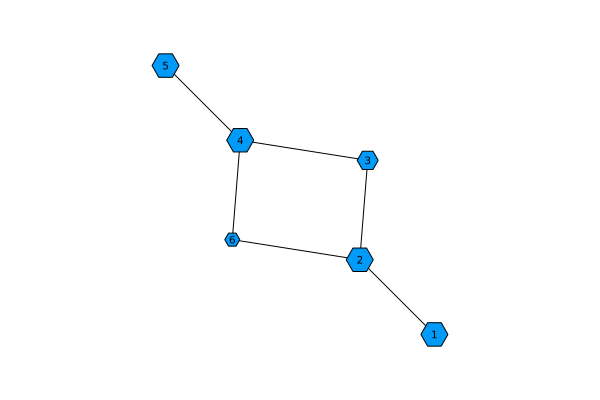

In [102]:
g = MetaGraphs.MetaGraph(Graphs.SimpleGraph(6))
vertex_weights = [
    1 => 3,
    2 => 3,
    3 => 2,
    4 => 3,
    5 => 3,
    6 => 1
]
for (vertex, weight) in vertex_weights
    MetaGraphs.set_prop!(g, vertex, :weight, weight)
end

# primary path
Graphs.add_edge!(g, 1, 2); 
Graphs.add_edge!(g, 2, 3)
Graphs.add_edge!(g, 3, 4)
Graphs.add_edge!(g, 4, 5)

# alternate path
Graphs.add_edge!(g, 2, 6)
Graphs.add_edge!(g, 6, 4)

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5
)

By default, we have a path that goes through the lowest frequency node

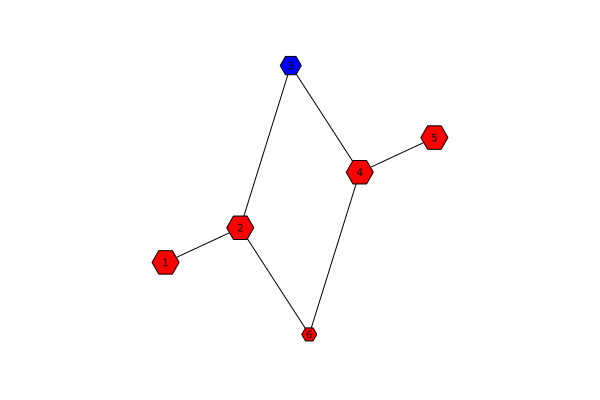

In [104]:
path = [1, 2, 6, 4, 5]
markercolor = [v in path ? :red : :blue for v in Graphs.vertices(g)]

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5,
    markercolor = markercolor
)

Now, let's say that we want to re-route around node 6

Here we define a distance matrix where `distance = 1 / mean(weight_v1, weight_v2)`

This enables use to maximize relative likelihood by minimizing distance such that shortest path algorithms will now find the maximum likelihood paths.

In [105]:
distance_matrix = ones(Graphs.nv(g), Graphs.nv(g))
for v1 in Graphs.vertices(g)
    weight_1 = g.vprops[v1][:weight]
    for v2 in Graphs.vertices(g)
        weight_2 = g.vprops[v2][:weight]
        distance_matrix[v1, v2] = 1 / Statistics.mean((weight_1, weight_2))
    end
end
distance_matrix

6×6 Matrix{Float64}:
 0.333333  0.333333  0.4       0.333333  0.333333  0.5
 0.333333  0.333333  0.4       0.333333  0.333333  0.5
 0.4       0.4       0.5       0.4       0.4       0.666667
 0.333333  0.333333  0.4       0.333333  0.333333  0.5
 0.333333  0.333333  0.4       0.333333  0.333333  0.5
 0.5       0.5       0.666667  0.5       0.5       1.0

To force-rerouting around 6, we'll set the distance from all nodes to 6 to infinity

In [106]:
distance_matrix[6, :] .= Inf
distance_matrix[:, 6] .= Inf
distance_matrix

6×6 Matrix{Float64}:
  0.333333   0.333333   0.4   0.333333   0.333333  Inf
  0.333333   0.333333   0.4   0.333333   0.333333  Inf
  0.4        0.4        0.5   0.4        0.4       Inf
  0.333333   0.333333   0.4   0.333333   0.333333  Inf
  0.333333   0.333333   0.4   0.333333   0.333333  Inf
 Inf        Inf        Inf   Inf        Inf        Inf

In [107]:
source = 1
target = 5

# @time a_star_path = Graphs.a_star(g, source, target, distance_matrix)
# a_star_shortest_path = vcat(a_star_path[1].src, map(e -> e.dst, a_star_path)...)

@time yen_k = Graphs.yen_k_shortest_paths(g, source, target, distance_matrix, 2)
alt_path = yen_k.paths[1]

  0.000193 seconds (256 allocations: 27.531 KiB)


5-element Vector{Int64}:
 1
 2
 3
 4
 5

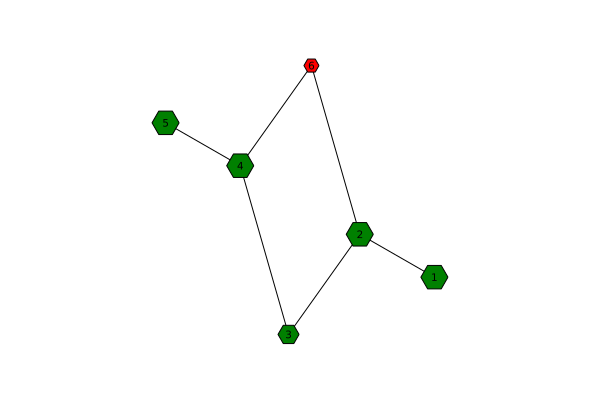

In [108]:
markercolor = [v in alt_path ? :green : markercolor[v] for v in Graphs.vertices(g)]

GraphRecipes.graphplot(
    g,
    curves=false,
    names=collect(Graphs.vertices(g)),
    node_weights=map(v -> g.vprops[v][:weight], Graphs.vertices(g)),
    nodesize=1/5,
    markercolor = markercolor
)